<a href="https://colab.research.google.com/github/Afealete/FOXTROT-2-ASSIGNMENT-2/blob/main/Group%204%20(FOXTROT-2)%20Project%20One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!dpkg --configure -a > /dev/null 2>&1
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-latex-extra > /dev/null 2>&1

!apt-get install pandoc > /dev/null 2>&1

# Add --output option to specify the output file name and location explicitly
!jupyter nbconvert --to pdf --output "Group 4 (FOXTROT-2) Project One.pdf" "/content/Group 4 (FOXTROT-2) Project One.ipynb"

from google.colab import files
files.download('Group 4 (FOXTROT-2) Project One.pdf')

# Case Study – Banking & Loans in Ghana

In today’s competitive and digitally driven financial environment, the ability to predict credit risk is a strategic advantage. GhanaLoanConnect, a digital lending platform connecting borrowers to investors, is actively seeking data-driven solutions to reduce its rate of non-performing loans (NPLs). Rising default rates not only impact profitability but also weaken lender trust and reduce platform credibility

To address this challenge, this project proposes the development of a machine learning model that can predict the likelihood of a borrower defaulting on a loan. With accurate predictions, GhanaLoanConnect can proactively minimize risk, prioritize low-risk borrowers, and enhance portfolio performance.

## Import Common Libraries

In [ ]:
# Import common libraries
!pip install fairlearn scikit-optimize xgboost imbalanced-learn
!pip install shap lime

import shap
import lime
import lime.lime_tabular

# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import RandomOverSampler

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)

# Fairness assessment
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import GridSearch, EqualizedOdds

# Other utilities
import warnings
import timeit
warnings.filterwarnings('ignore')

## Load Dataset

In [ ]:
# Load dataset
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('/content/loan_borowwer_data.csv')
data

Saving loan_borowwer_data.csv to loan_borowwer_data (2).csv


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


## Exploratory Data Analysis

In [ ]:
# Define sensitive attribute
sensitive_attribute_name = 'fico'
A = data[[sensitive_attribute_name]]
X = data.drop(['not.fully.paid', sensitive_attribute_name], axis=1)
y = data['not.fully.paid']

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB
None

Descriptive Statistics:
       credit.policy  

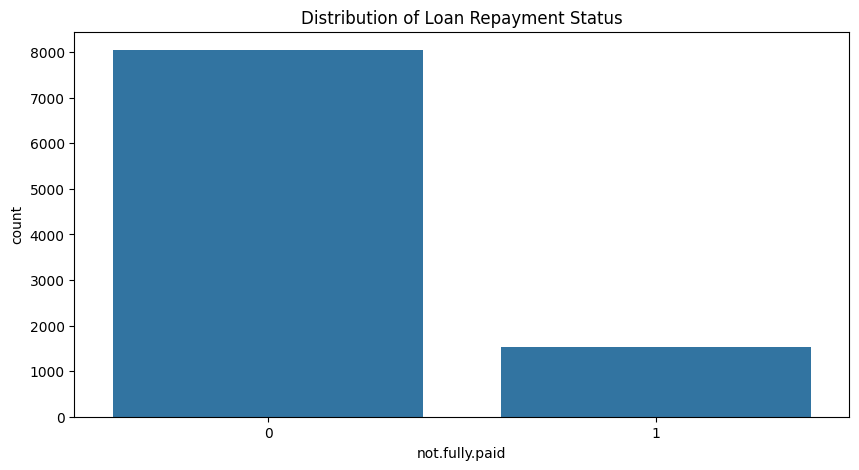

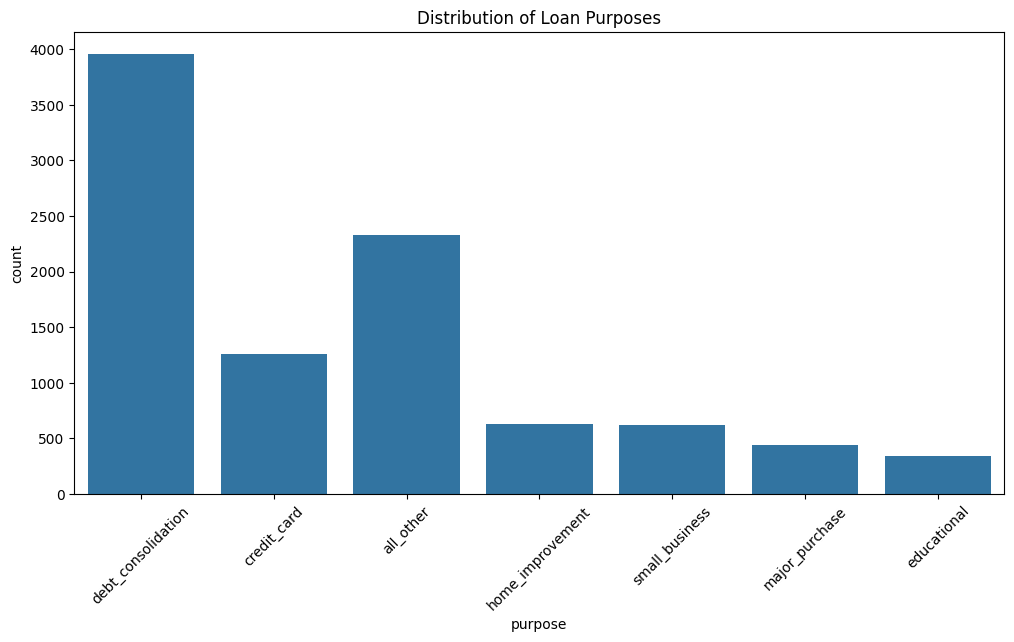

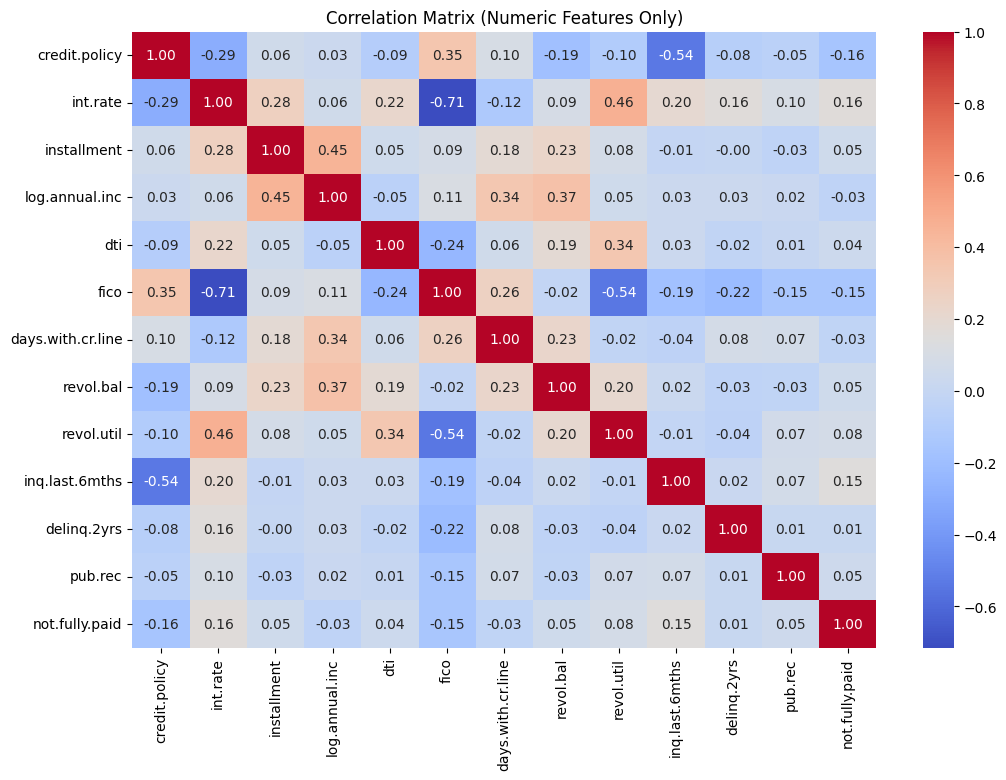

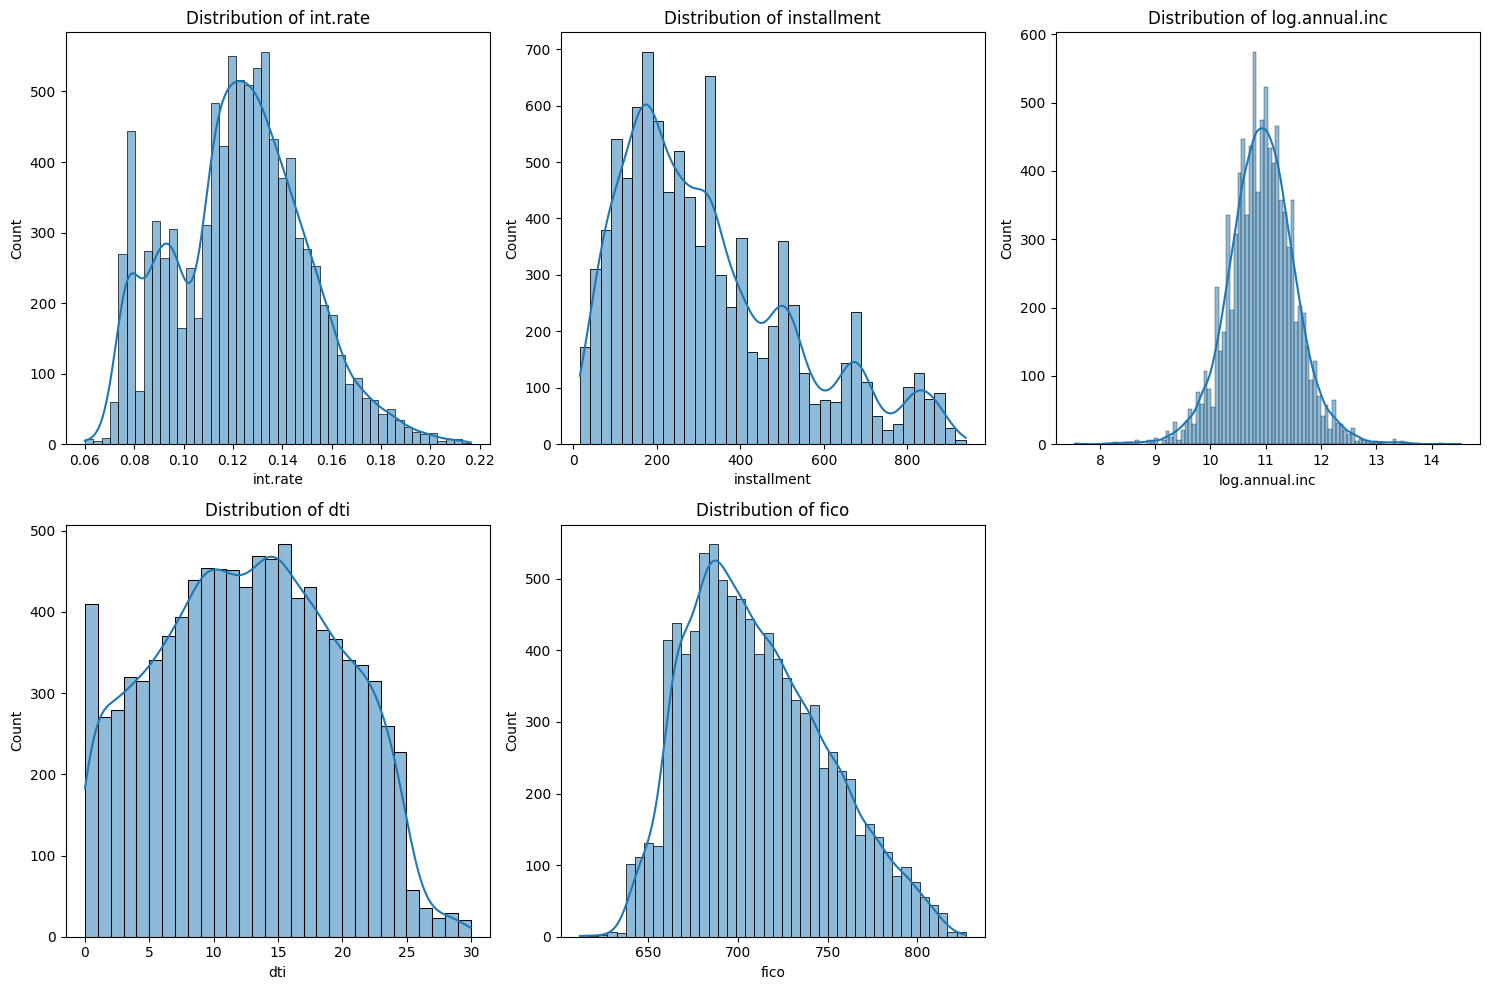


Detailed Insights from the Visualizations:

Loan repayment status distribution:
not.fully.paid
0    83.994571
1    16.005429
Name: proportion, dtype: float64
This shows the proportion of loans that were fully paid versus not. If there's a large imbalance, it may suggest risk patterns in lending.

Loan purposes distribution:
purpose
debt_consolidation    41.313427
all_other             24.337022
credit_card           13.176028
home_improvement       6.567133
small_business         6.462727
major_purchase         4.562539
educational            3.581123
Name: proportion, dtype: float64
This highlights the most common reasons for borrowing. If one category dominates, it may indicate trends in loan demands.

Highly correlated numeric features:
Empty DataFrame
Columns: [credit.policy, int.rate, installment, log.annual.inc, dti, fico, days.with.cr.line, revol.bal, revol.util, inq.last.6mths, delinq.2yrs, pub.rec, not.fully.paid]
Index: []
Strong positive correlations suggest features that m

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_visualization(data):
    """Generate textual insights based on data analysis"""

    insights = []

    # Loan repayment status distribution insights
    repayment_counts = data['not.fully.paid'].value_counts(normalize=True) * 100
    insights.append(f"\nLoan repayment status distribution:\n{repayment_counts}\n"
                    "This shows the proportion of loans that were fully paid versus not. "
                    "If there's a large imbalance, it may suggest risk patterns in lending.")

    # Loan purposes insights
    purpose_counts = data['purpose'].value_counts(normalize=True) * 100
    insights.append(f"\nLoan purposes distribution:\n{purpose_counts}\n"
                    "This highlights the most common reasons for borrowing. "
                    "If one category dominates, it may indicate trends in loan demands.")

    # Correlation matrix insights
    correlation_matrix = data.select_dtypes(include=['int64', 'float64']).corr()
    high_correlations = correlation_matrix[(correlation_matrix > 0.6) & (correlation_matrix < 1.0)]
    insights.append(f"\nHighly correlated numeric features:\n{high_correlations.dropna(how='all')}\n"
                    "Strong positive correlations suggest features that may impact loan repayment. "
                    "For example, if FICO scores strongly correlate with repayment, it indicates creditworthiness plays a significant role.")

    # Numeric feature distributions insights
    numeric_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico']
    for col in numeric_features:
        mean_val = data[col].mean()
        std_dev = data[col].std()
        insights.append(f"\nFeature: {col}\nMean: {mean_val:.2f}, Std Dev: {std_dev:.2f}\n"
                        f"This shows the average value and variability of {col}. "
                        "Higher variability may suggest unpredictable trends or outliers.")

    return "\n".join(insights)

def perform_eda(data):
    """Perform EDA and include detailed explanations"""

    print("Data Info:")
    print(data.info())

    print("\nDescriptive Statistics:")
    print(data.describe())

    print("\nMissing Values:")
    print(data.isnull().sum())

    # Target variable distribution
    plt.figure(figsize=(10, 5))
    sns.countplot(x='not.fully.paid', data=data)
    plt.title('Distribution of Loan Repayment Status')
    plt.show()

    # For categorical variable
    plt.figure(figsize=(12, 6))
    sns.countplot(x='purpose', data=data)
    plt.title('Distribution of Loan Purposes')
    plt.xticks(rotation=45)
    plt.show()

    # Correlation matrix (numeric features only)
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(12, 8))
    sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix (Numeric Features Only)')
    plt.show()

    # Additional numeric feature distributions
    numeric_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico']
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_features, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # Generate textual explanations
    print("\nDetailed Insights from the Visualizations:")
    print(analyze_visualization(data))

# Call the function with the dataset
perform_eda(data)


## Data Preprocessing and Feature Engineering

In [ ]:
#Data Preprocessing

def preprocess_data(data):
    # One-hot encoding for categorical features
    data = pd.get_dummies(data, columns=['purpose'], drop_first=True)

    # Handle class imbalance
    X = data.drop('not.fully.paid', axis=1)
    y = data['not.fully.paid']

    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Feature engineering
    data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

    # Create new features
    epsilon = 1e-6
    data_resampled["debt_to_income_ratio"] = data_resampled["installment"] / data_resampled["log.annual.inc"]
    data_resampled["loan_to_income"] = data_resampled["installment"] / np.exp(data_resampled["log.annual.inc"])
    data_resampled["credit_utilization"] = data_resampled["revol.bal"] / (data_resampled["revol.util"] + epsilon)
    data_resampled["payment_to_income_ratio"] = data_resampled["installment"] / data_resampled["log.annual.inc"]

    # Handle infinite values
    data_resampled.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_resampled.fillna(data_resampled.median(), inplace=True)

    return data_resampled

processed_data = preprocess_data(data)

## Model Training and Evaluation


Training Logistic Regression...


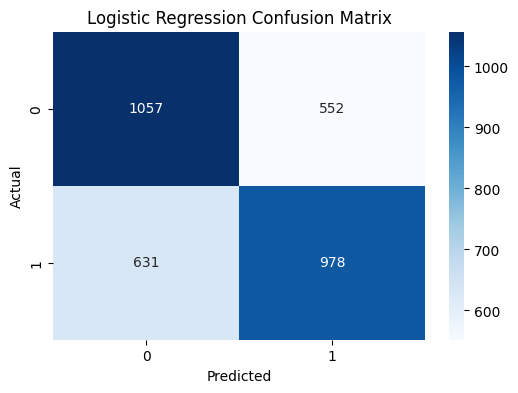


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      1609
           1       0.64      0.61      0.62      1609

    accuracy                           0.63      3218
   macro avg       0.63      0.63      0.63      3218
weighted avg       0.63      0.63      0.63      3218


Training Decision Tree...


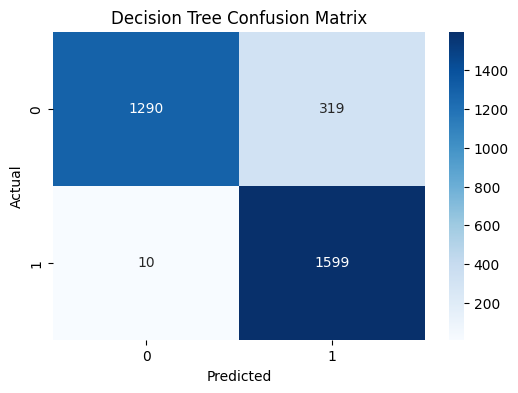


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      1609
           1       0.83      0.99      0.91      1609

    accuracy                           0.90      3218
   macro avg       0.91      0.90      0.90      3218
weighted avg       0.91      0.90      0.90      3218


Training Random Forest...


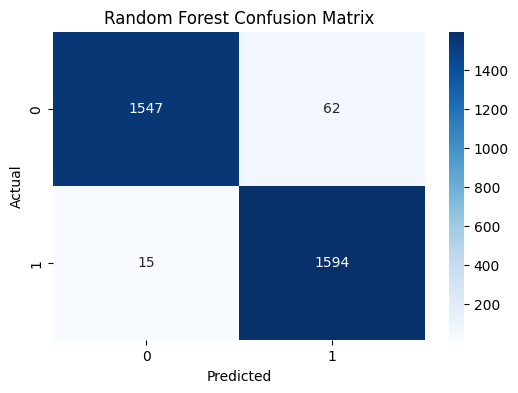


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1609
           1       0.96      0.99      0.98      1609

    accuracy                           0.98      3218
   macro avg       0.98      0.98      0.98      3218
weighted avg       0.98      0.98      0.98      3218


Training XGBoost...


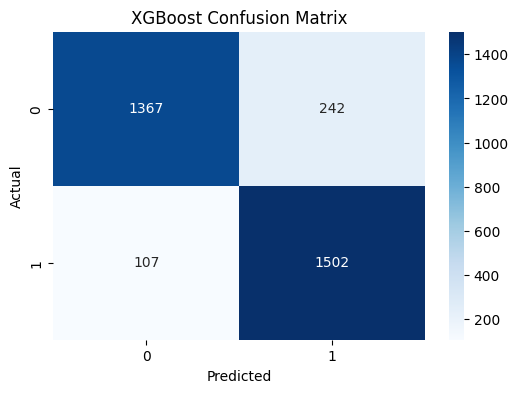


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1609
           1       0.86      0.93      0.90      1609

    accuracy                           0.89      3218
   macro avg       0.89      0.89      0.89      3218
weighted avg       0.89      0.89      0.89      3218


Training Gradient Boosting...


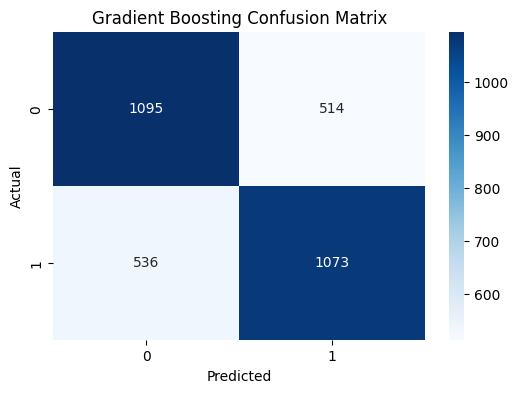


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      1609
           1       0.68      0.67      0.67      1609

    accuracy                           0.67      3218
   macro avg       0.67      0.67      0.67      3218
weighted avg       0.67      0.67      0.67      3218


Model Performance Comparison:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC  \
Logistic Regression  0.632380   0.639216  0.607831  0.623128  0.693780   
Decision Tree        0.897763   0.833681  0.993785  0.906720  0.897763   
Random Forest        0.976072   0.962560  0.990677  0.976417  0.997699   
XGBoost              0.891548   0.861239  0.933499  0.895914  0.962847   
Gradient Boosting    0.673710   0.676118  0.666874  0.671464  0.747057   

                     Training Time  Prediction Time  
Logistic Regression       0.050633         0.001370  
Decision Tree             0.237822         0.00

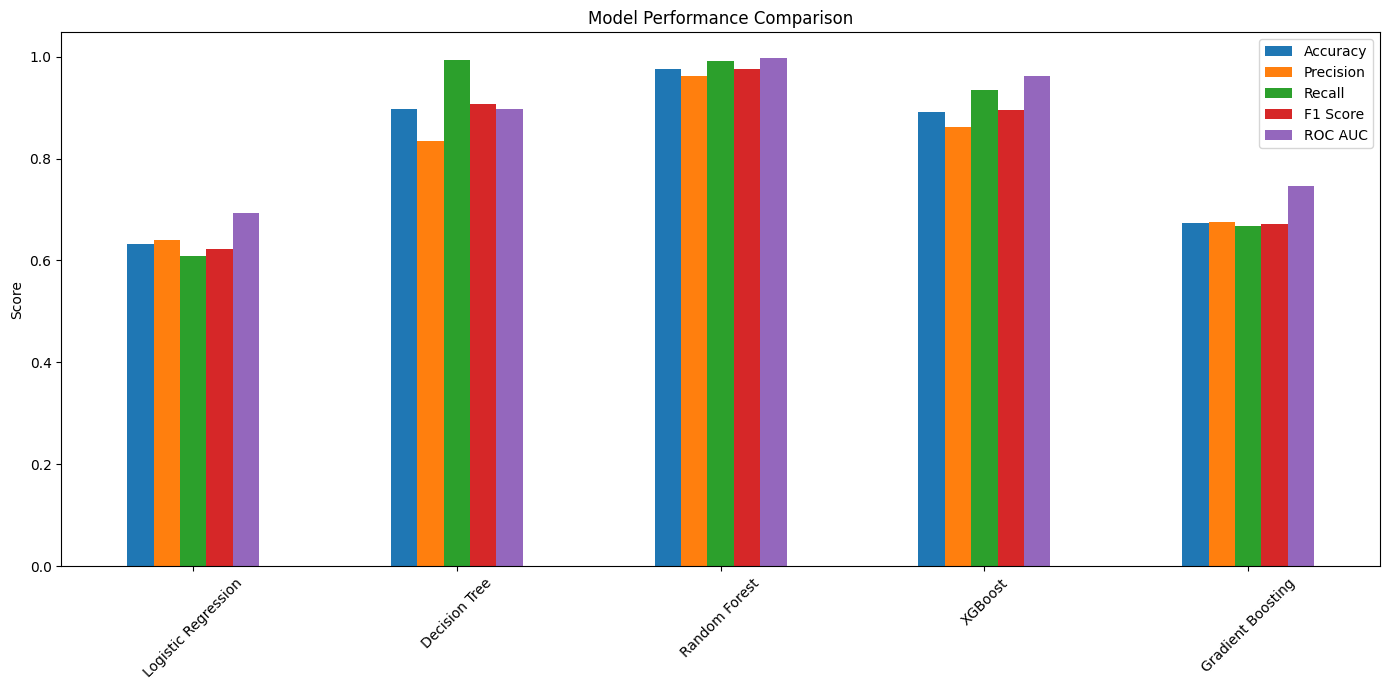

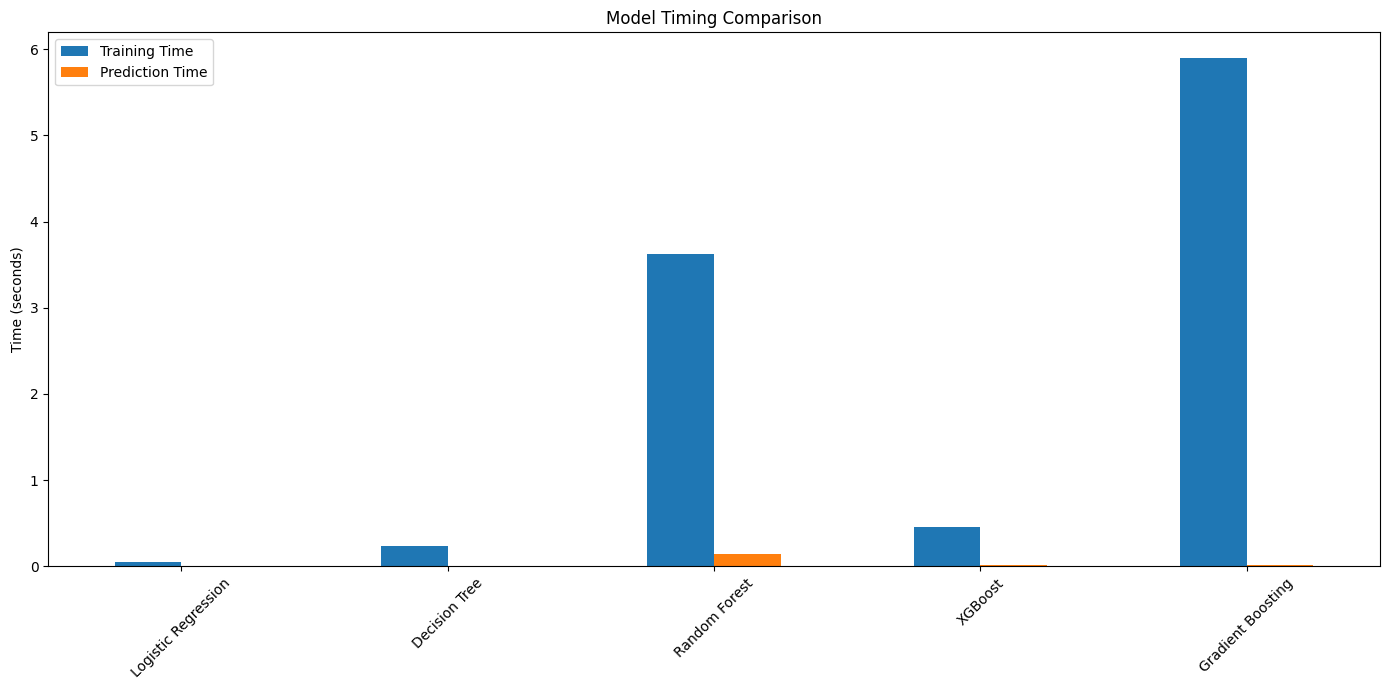

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time,Prediction Time
Logistic Regression,0.632380,0.639216,0.607831,0.623128,0.693780,0.050633,0.001370
Decision Tree,0.897763,0.833681,0.993785,0.906720,0.897763,0.237822,0.002301
Random Forest,0.976072,0.962560,0.990677,0.976417,0.997699,3.628147,0.148387
XGBoost,0.891548,0.861239,0.933499,0.895914,0.962847,0.451608,0.017569
Gradient Boosting,0.673710,0.676118,0.666874,0.671464,0.747057,5.901984,0.011847


In [ ]:
#Model Training and Evaluation
def train_and_evaluate_models(data):
    # Prepare data
    X = data.drop('not.fully.paid', axis=1)
    y = data['not.fully.paid']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }



    # Train and evaluate models
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Time training
        start_time = timeit.default_timer()
        model.fit(X_train_scaled, y_train)
        training_time = timeit.default_timer() - start_time

        # Predictions
        start_time = timeit.default_timer()
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        prediction_time = timeit.default_timer() - start_time

        # Calculate metrics
        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob),
            'Training Time': training_time,
            'Prediction Time': prediction_time
        }

        results[name] = metrics

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Classification report
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))

    # Display results
    results_df = pd.DataFrame(results).T
    print("\nModel Performance Comparison:")
    print(results_df)

    # Plot metrics
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    results_df[metrics_to_plot].plot(kind='bar', figsize=(14, 7))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot timing
    results_df[['Training Time', 'Prediction Time']].plot(kind='bar', figsize=(14, 7))
    plt.title('Model Timing Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return results_df, models

results_df, models = train_and_evaluate_models(processed_data)
results_df



## Fairness Analysis


Fairness Analysis:

Analyzing fairness for Logistic Regression...

Performance by fico:
      accuracy  precision    recall        f1
fico                                         
617   0.000000   0.000000  0.000000  0.000000
627   0.000000   0.000000  0.000000  0.000000
632   0.333333   0.000000  0.000000  0.000000
642   0.823529   0.500000  0.333333  0.400000
647   0.678571   1.000000  0.250000  0.400000
652   0.730769   0.000000  0.000000  0.000000
657   0.733333   1.000000  0.200000  0.333333
662   0.779221   1.000000  0.055556  0.105263
667   0.771084   0.666667  0.100000  0.173913
672   0.750000   0.000000  0.000000  0.000000
677   0.826087   0.000000  0.000000  0.000000
682   0.807339   0.250000  0.052632  0.086957
687   0.766355   0.500000  0.040000  0.074074
692   0.866667   0.000000  0.000000  0.000000
697   0.851485   0.000000  0.000000  0.000000
702   0.825581   0.000000  0.000000  0.000000
707   0.864583   0.000000  0.000000  0.000000
712   0.833333   0.000000  0.000000  

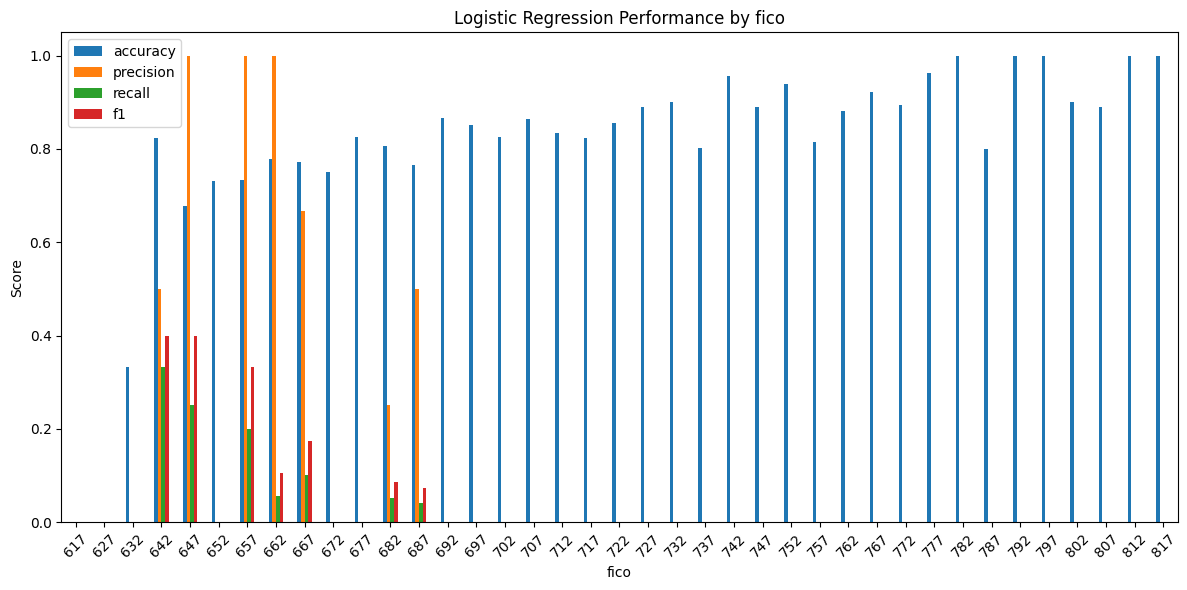


Analyzing fairness for Decision Tree...

Performance by fico:
      accuracy  precision    recall        f1
fico                                         
617   0.000000   0.000000  0.000000  0.000000
627   0.000000   0.000000  0.000000  0.000000
632   0.333333   0.500000  0.500000  0.500000
642   0.529412   0.000000  0.000000  0.000000
647   0.464286   0.285714  0.166667  0.210526
652   0.653846   0.333333  0.285714  0.307692
657   0.600000   0.375000  0.300000  0.333333
662   0.779221   0.533333  0.444444  0.484848
667   0.650602   0.263158  0.250000  0.256410
672   0.607143   0.066667  0.050000  0.057143
677   0.771739   0.352941  0.375000  0.363636
682   0.706422   0.275862  0.421053  0.333333
687   0.682243   0.320000  0.320000  0.320000
692   0.766667   0.187500  0.272727  0.222222
697   0.762376   0.235294  0.266667  0.250000
702   0.744186   0.266667  0.266667  0.266667
707   0.812500   0.250000  0.250000  0.250000
712   0.794872   0.363636  0.307692  0.333333
717   0.788235   

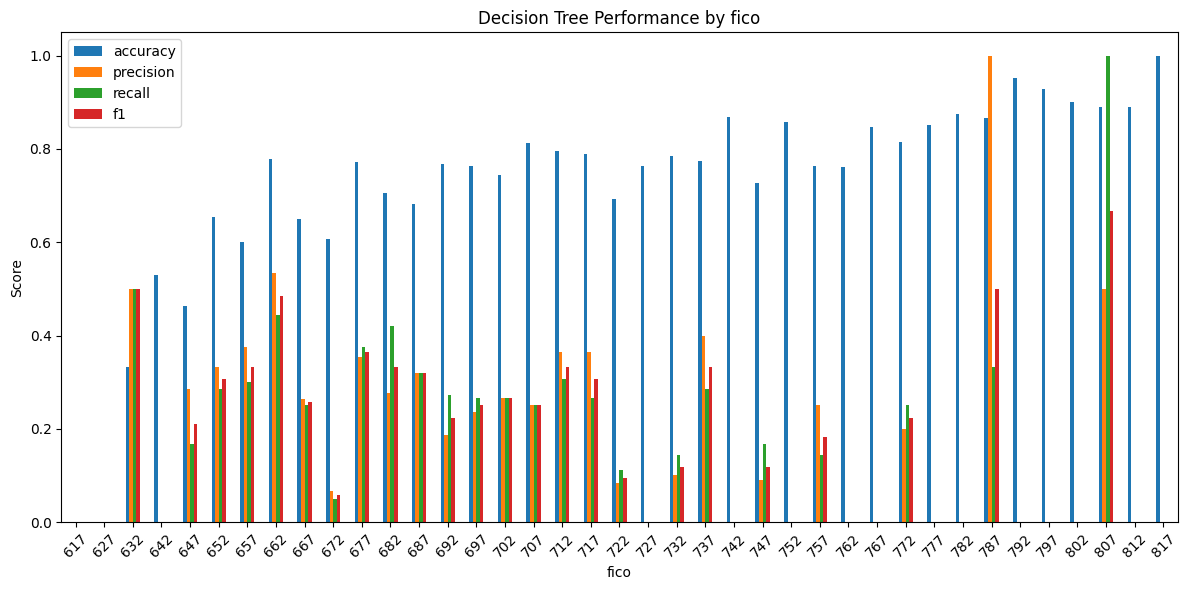


Analyzing fairness for Random Forest...

Performance by fico:
      accuracy  precision    recall        f1
fico                                         
617   0.000000        0.0  0.000000  0.000000
627   0.000000        0.0  0.000000  0.000000
632   0.333333        0.0  0.000000  0.000000
642   0.823529        0.0  0.000000  0.000000
647   0.607143        1.0  0.083333  0.153846
652   0.730769        0.0  0.000000  0.000000
657   0.633333        0.0  0.000000  0.000000
662   0.753247        0.0  0.000000  0.000000
667   0.771084        1.0  0.050000  0.095238
672   0.761905        0.0  0.000000  0.000000
677   0.826087        0.0  0.000000  0.000000
682   0.816514        0.0  0.000000  0.000000
687   0.766355        0.0  0.000000  0.000000
692   0.866667        0.0  0.000000  0.000000
697   0.851485        0.0  0.000000  0.000000
702   0.825581        0.0  0.000000  0.000000
707   0.875000        0.0  0.000000  0.000000
712   0.833333        0.0  0.000000  0.000000
717   0.823529   

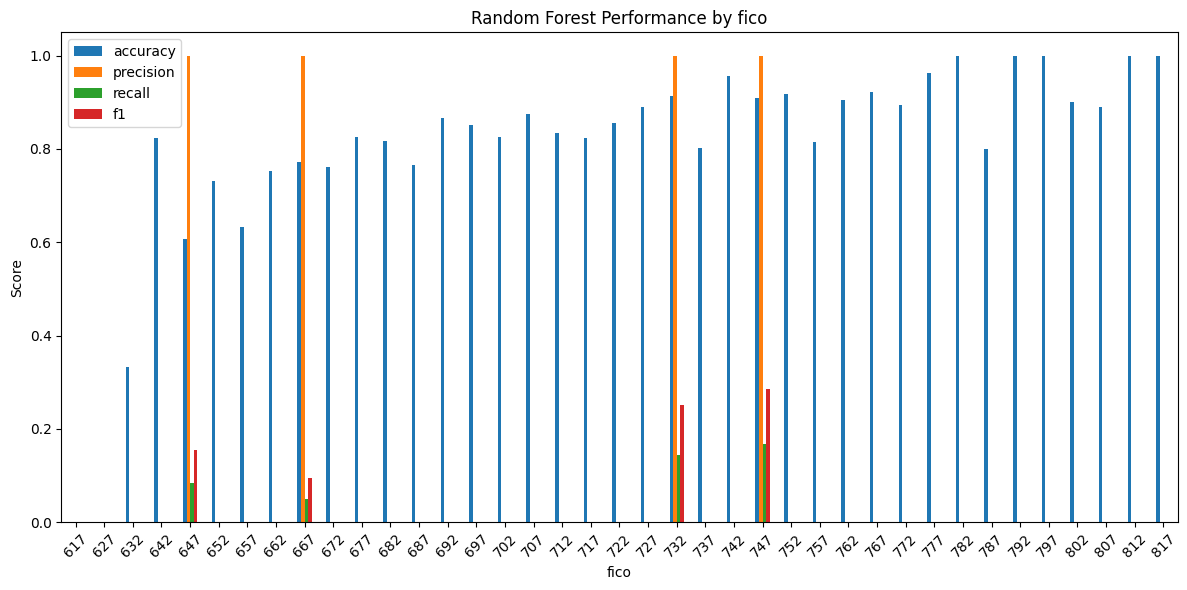


Analyzing fairness for XGBoost...

Performance by fico:
      accuracy  precision    recall        f1
fico                                         
617   0.000000   0.000000  0.000000  0.000000
627   0.000000   0.000000  0.000000  0.000000
632   0.333333   0.000000  0.000000  0.000000
642   0.823529   0.500000  0.333333  0.400000
647   0.535714   0.333333  0.083333  0.133333
652   0.653846   0.000000  0.000000  0.000000
657   0.666667   0.500000  0.200000  0.285714
662   0.727273   0.285714  0.111111  0.160000
667   0.674699   0.111111  0.050000  0.068966
672   0.750000   0.428571  0.150000  0.222222
677   0.826087   0.500000  0.062500  0.111111
682   0.825688   0.500000  0.105263  0.173913
687   0.719626   0.000000  0.000000  0.000000
692   0.855556   0.250000  0.090909  0.133333
697   0.861386   0.666667  0.133333  0.222222
702   0.837209   1.000000  0.066667  0.125000
707   0.843750   0.000000  0.000000  0.000000
712   0.820513   0.333333  0.076923  0.125000
717   0.823529   0.0000

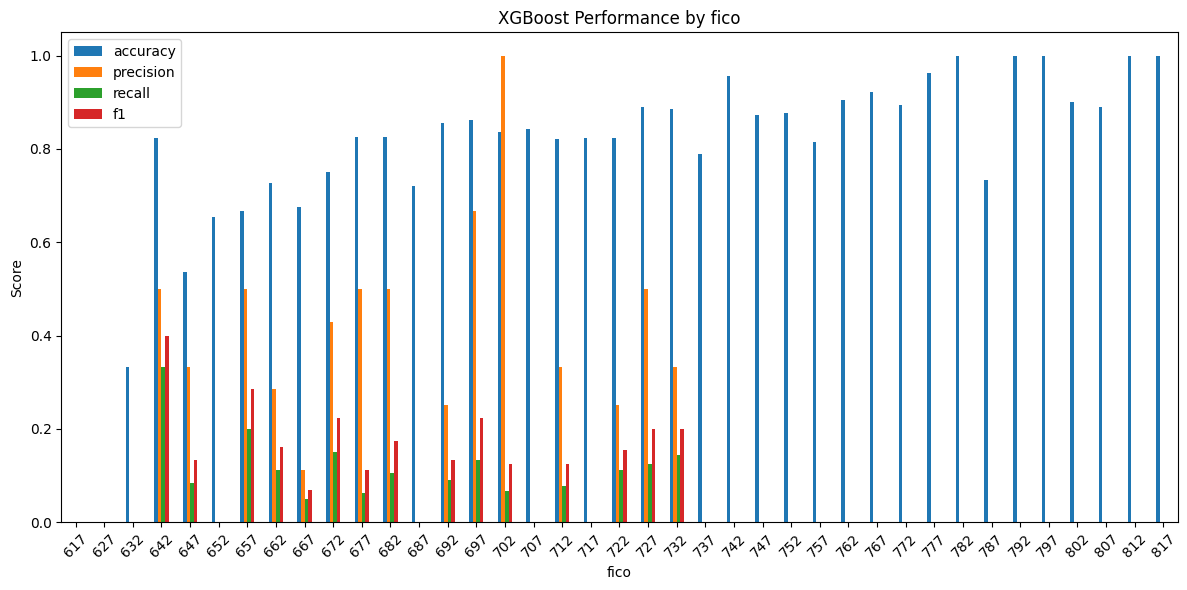


Analyzing fairness for Gradient Boosting...

Performance by fico:
      accuracy  precision    recall        f1
fico                                         
617   0.000000   0.000000  0.000000  0.000000
627   0.000000   0.000000  0.000000  0.000000
632   0.333333   0.000000  0.000000  0.000000
642   0.705882   0.000000  0.000000  0.000000
647   0.571429   0.000000  0.000000  0.000000
652   0.730769   0.000000  0.000000  0.000000
657   0.700000   0.666667  0.200000  0.307692
662   0.753247   0.000000  0.000000  0.000000
667   0.771084   0.666667  0.100000  0.173913
672   0.750000   0.000000  0.000000  0.000000
677   0.826087   0.000000  0.000000  0.000000
682   0.816514   0.000000  0.000000  0.000000
687   0.757009   0.000000  0.000000  0.000000
692   0.866667   0.000000  0.000000  0.000000
697   0.851485   0.000000  0.000000  0.000000
702   0.825581   0.000000  0.000000  0.000000
707   0.854167   0.000000  0.000000  0.000000
712   0.833333   0.000000  0.000000  0.000000
717   0.82352

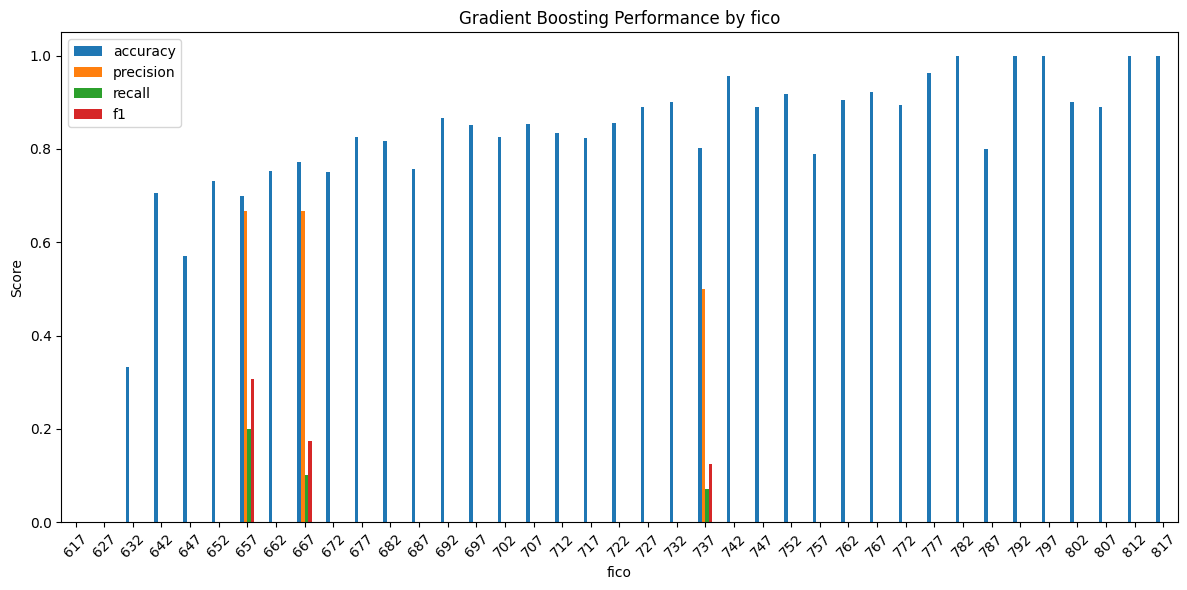

{'Logistic Regression': {'Demographic Parity Difference': np.float64(0.11764705882352941),
  'Equalized Odds Difference': 0.3333333333333333,
  'Performance by Group':       accuracy  precision    recall        f1
  fico                                         
  617   0.000000   0.000000  0.000000  0.000000
  627   0.000000   0.000000  0.000000  0.000000
  632   0.333333   0.000000  0.000000  0.000000
  642   0.823529   0.500000  0.333333  0.400000
  647   0.678571   1.000000  0.250000  0.400000
  652   0.730769   0.000000  0.000000  0.000000
  657   0.733333   1.000000  0.200000  0.333333
  662   0.779221   1.000000  0.055556  0.105263
  667   0.771084   0.666667  0.100000  0.173913
  672   0.750000   0.000000  0.000000  0.000000
  677   0.826087   0.000000  0.000000  0.000000
  682   0.807339   0.250000  0.052632  0.086957
  687   0.766355   0.500000  0.040000  0.074074
  692   0.866667   0.000000  0.000000  0.000000
  697   0.851485   0.000000  0.000000  0.000000
  702   0.825581  

In [ ]:
#Fairness Analysis
def perform_fairness_analysis(models, data):
    # Prepare data (using original data before resampling for fairness analysis)
    # First, properly one-hot encode the purpose column
    data = pd.get_dummies(data, columns=['purpose'], drop_first=True)

    X = data.drop(['not.fully.paid', sensitive_attribute_name], axis=1)
    y = data['not.fully.paid']
    A = data[sensitive_attribute_name]

    # Split data
    X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
        X, y, A, test_size=0.2, random_state=42, stratify=y)

    # Identify numeric columns (excluding one-hot encoded columns)
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

    # Scale only numeric features
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

    print("\nFairness Analysis:")
    fairness_results = {}

    for name, model in models.items():
        print(f"\nAnalyzing fairness for {name}...")

        # Train model on original data (not resampled)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Fairness metrics
        metrics = {
            'accuracy': accuracy_score,
            'precision': precision_score,
            'recall': recall_score,
            'f1': f1_score
        }

        metric_frame = MetricFrame(
            metrics=metrics,
            y_true=y_test,
            y_pred=y_pred,
            sensitive_features=A_test
        )

        dp_diff = demographic_parity_difference(
            y_true=y_test,
            y_pred=y_pred,
            sensitive_features=A_test
        )

        eo_diff = equalized_odds_difference(
            y_true=y_test,
            y_pred=y_pred,
            sensitive_features=A_test
        )

        print(f"\nPerformance by {sensitive_attribute_name}:")
        print(metric_frame.by_group)

        print(f"\nDemographic Parity Difference: {dp_diff:.4f}")
        print(f"Equalized Odds Difference: {eo_diff:.4f}")

        fairness_results[name] = {
            'Demographic Parity Difference': dp_diff,
            'Equalized Odds Difference': eo_diff,
            'Performance by Group': metric_frame.by_group
        }

        # Plot performance by group
        metric_frame.by_group.plot(kind='bar', figsize=(12, 6))
        plt.title(f'{name} Performance by {sensitive_attribute_name}')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return fairness_results

fairness_results = perform_fairness_analysis(models, data)
fairness_results

                 Model   DP_diff   EO_diff
2        Random Forest  0.035714  0.166667
4    Gradient Boosting  0.117647  0.200000
3              XGBoost  0.133333  0.333333
0  Logistic Regression  0.117647  0.333333
1        Decision Tree  0.666667  1.000000


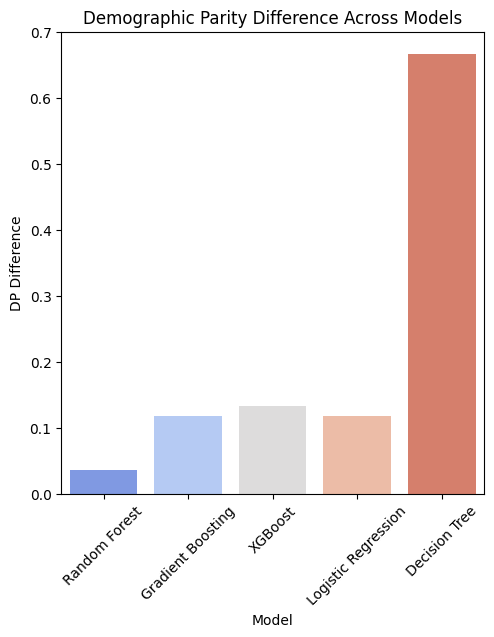


Explanation: This bar plot illustrates how different models compare in terms of Demographic Parity Difference. A lower DP Difference suggests that the model treats demographic groups more equitably, while a higher difference indicates potential bias where certain groups receive disproportionate outcomes.


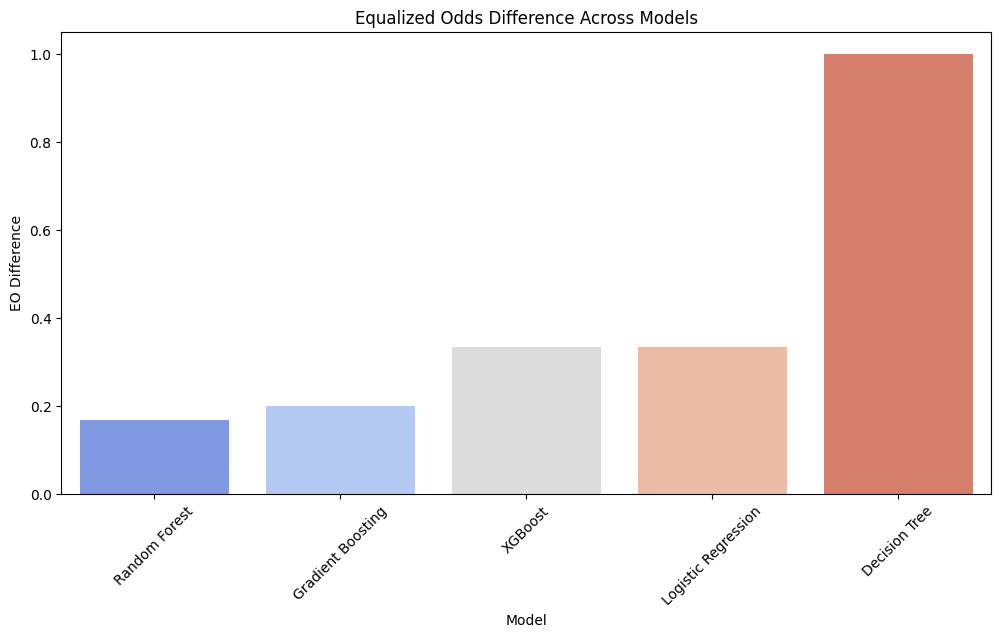


Explanation: The Equalized Odds Difference measures how equally a model predicts outcomes across different groups given the same ground truth labels. If a model has a higher EO Difference, it suggests potential disparities in its predictive fairness, meaning that some groups might be systematically disadvantaged. Ideally, models should have low EO differences to ensure fairness in predictive outcomes.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compare fairness metrics across models
fairness_comparison = pd.DataFrame({
    'Model': list(fairness_results.keys()),
    'DP_diff': [r['Demographic Parity Difference'] for r in fairness_results.values()],
    'EO_diff': [r['Equalized Odds Difference'] for r in fairness_results.values()]
})

# Sort by Equalized Odds Difference
fairness_comparison = fairness_comparison.sort_values('EO_diff')

# Print sorted fairness comparison table
print(fairness_comparison)

# Visualization of fairness metrics
plt.figure(figsize=(12, 6))

# Bar plot for Demographic Parity Difference
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='DP_diff', data=fairness_comparison, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Demographic Parity Difference Across Models')
plt.ylabel('DP Difference')
plt.xlabel('Model')
plt.show()

print("\nExplanation: This bar plot illustrates how different models compare in terms of Demographic Parity Difference. "
      "A lower DP Difference suggests that the model treats demographic groups more equitably, while a higher difference "
      "indicates potential bias where certain groups receive disproportionate outcomes.")

# Bar plot for Equalized Odds Difference
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='EO_diff', data=fairness_comparison, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Equalized Odds Difference Across Models')
plt.ylabel('EO Difference')
plt.xlabel('Model')
plt.show()

print("\nExplanation: The Equalized Odds Difference measures how equally a model predicts outcomes across different groups "
      "given the same ground truth labels. If a model has a higher EO Difference, it suggests potential disparities in its "
      "predictive fairness, meaning that some groups might be systematically disadvantaged. Ideally, models should have low EO differences "
      "to ensure fairness in predictive outcomes.")
